In [25]:
import pickle
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from src.auxil import network_rmse, plot_estimates, plot_rmse, plot_traj, rmse
from src.kalmanfilter import KalmanFilter
from src.kfnet import KFNet
from src.statespace import CAModel, CVModel, RWModel, StateSpace
from src.trajectory import Trajectory

sns.set_style("white")

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# Simulation parameters
RUNS = 20
NETWORK_FILE = "../networks/network_15_6.pkl"
FILEPATH_CSV = "./sim_results/avg_rmse.csv"
RANDOM_SEED = None

# Trajectory generator parameters
ndat = 500
q = 9.5e-5  # Process noise intensity
r = 1.3  # Observation noise std
TRAJ_MODEL = CAModel(q, r)
INIT_STATE = np.zeros(6)

# Additional filter parameters
c_rwm = 15  # RWM process noise scaling constant
c_cvm = 5
expf = 0.95  # Exponential forgetting param
reset_thresh = 5.0  # Filter reset threshold (Euclidean distance from centroid)

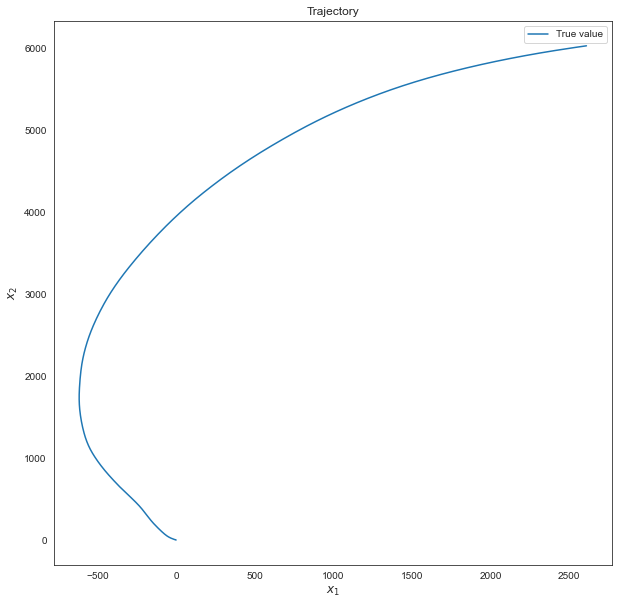

In [28]:
# Generate a trajectory
traj = Trajectory(
    TRAJ_MODEL, n_steps=ndat, init_state=INIT_STATE, R=None, random_seed=RANDOM_SEED
)

plot_traj(traj)

In [29]:
rmse_rwm1 = np.zeros((ndat, 2))
rmse_rwm2 = np.zeros((ndat, 2))

# No coop nodes
rmse_rwmnc = np.zeros((ndat, 2))
rmse_camnc = np.zeros((ndat, 2))
rmse_cvmnc = np.zeros((ndat, 2))

# Run simulations
for i in range(RUNS):
    # Initialize network
    kfs = [
        KalmanFilter(RWModel(20 * q, r), lambda_expf=expf),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(RWModel(c_rwm * q, r), lambda_expf=expf),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
    ]

    ###
    rwmnc = KalmanFilter(RWModel(c_rwm * q, r), lambda_expf=expf)
    cvmnc = KalmanFilter(CVModel(q, r))
    camnc = KalmanFilter(CAModel(q, r))

    # Load network topology file
    kfn = None
    with open(NETWORK_FILE, "rb") as f:
        kfn = pickle.load(f)
    kfn.assign(init=kfs)
    kfn.generate_txt_labels()

    # Add observation noise for each node
    # traj.simulate(ndat, INIT_STATE)
    R = kfn.observation_covs()
    traj.add_obs_noise(R)

    # Run estimation
    for yt in traj.observations:
        kfn.time_step(
            yt,
            predict=True,
            update=True,
            adapt=True,
            combine=True,
            reset_strategy="mean",
            reset_thresh=reset_thresh,
            c=0.95,
        )

        rwmnc.predict()
        rwmnc.update(yt[0], log=True)

        cvmnc.predict()
        cvmnc.update(yt[5], log=True)

        camnc.predict()
        camnc.update(yt[4], log=True)

    # Save results
    RWM_1 = kfs[0]
    RWM_2 = kfs[11]

    rmse_rwm1 += rmse(traj.X[:, :2], RWM_1.history[:, :2], n=ndat)
    rmse_rwm2 += rmse(traj.X[:, :2], RWM_2.history[:, :2], n=ndat)

    rmse_rwmnc += rmse(traj.X[:, :2], rwmnc.history[:, :2], n=ndat)
    rmse_cvmnc += rmse(traj.X[:, :2], cvmnc.history[:, :2], n=ndat)
    rmse_camnc += rmse(traj.X[:, :2], camnc.history[:, :2], n=ndat)

In [30]:
# kfn.draw_network()

In [31]:
# Average the results
rmse_rwm1 /= RUNS
rmse_rwm2 /= RUNS

rmse_rwmnc /= RUNS
rmse_cvmnc /= RUNS
rmse_camnc /= RUNS

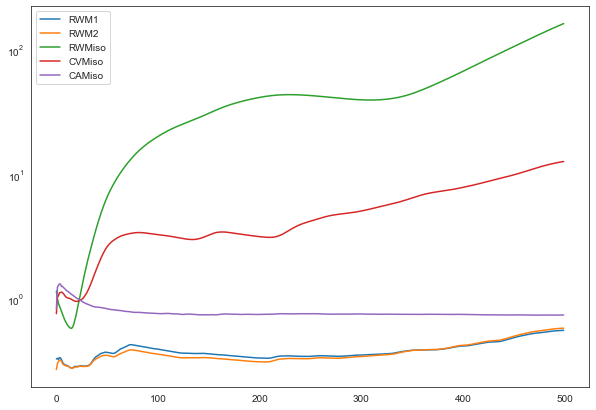

In [32]:
plt.figure(figsize=(10, 7))
plt.plot(rmse_rwm1[:, 0], label="RWM1")
plt.plot(rmse_rwm2[:, 0], label="RWM2")

plt.plot(rmse_rwmnc[:, 0], label="RWMiso")
plt.plot(rmse_cvmnc[:, 0], label="CVMiso")
plt.plot(rmse_camnc[:, 0], label="CAMiso")

plt.yscale("log", base=10)
plt.legend()
plt.show()

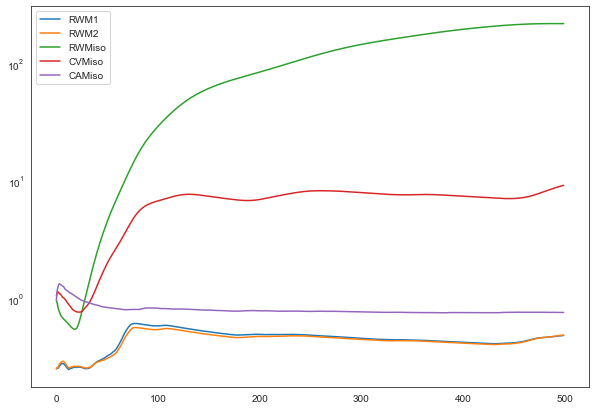

In [33]:
plt.figure(figsize=(10, 7))
plt.plot(rmse_rwm1[:, 1], label="RWM1")
plt.plot(rmse_rwm2[:, 1], label="RWM2")

plt.plot(rmse_rwmnc[:, 1], label="RWMiso")
plt.plot(rmse_cvmnc[:, 1], label="CVMiso")
plt.plot(rmse_camnc[:, 1], label="CAMiso")

plt.yscale("log", base=10)
plt.legend()
plt.show()

In [34]:
# CSV column labels
cols = []
for n in chain(kfn._txt_labels, ["RWM_NC", "CVM_NC", "CAM_NC"]):
    for x in ("x1", "x2"):
        cols.append(n + "_" + x)

data = network_rmse(kfn, traj, ndat, 2, rwmnc, cvmnc, camnc)

In [35]:
# Generate CSV files
df = pd.DataFrame(data=data, columns=cols)
# df.to_csv(FILEPATH_CSV, index_label="t")
df.head()

,RWM_1_x1,RWM_1_x2,CVM_1_x1,CVM_1_x2,CVM_2_x1,CVM_2_x2,CVM_3_x1,CVM_3_x2,CVM_4_x1,CVM_4_x2,...,CAM_4_x1,CAM_4_x2,CAM_5_x1,CAM_5_x2,RWM_NC_x1,RWM_NC_x2,CVM_NC_x1,CVM_NC_x2,CAM_NC_x1,CAM_NC_x2
0,0.027422,0.314830,0.118603,0.594806,0.182062,0.540281,0.182024,0.530051,0.278530,0.690683,...,0.087986,0.266651,0.004003,0.213813,0.589696,0.562769,0.748462,0.793793,2.104802,1.342299
1,0.028219,0.392582,0.347937,0.557012,0.267243,0.443250,0.340804,0.476984,0.380915,0.627587,...,0.173760,0.306985,0.228752,0.229803,0.564988,0.503590,1.311486,0.861226,1.493029,0.954715
2,0.034713,0.343045,0.293245,0.457487,0.222055,0.363230,0.280905,0.391281,0.311046,0.516941,...,0.151657,0.250706,0.186776,0.190407,0.638940,0.484555,1.076033,0.710386,1.219378,1.243813
3,0.146437,0.318850,0.342355,0.417593,0.313967,0.350739,0.335744,0.373115,0.367023,0.479179,...,0.261493,0.233657,0.309362,0.196020,0.585559,0.422708,0.958279,0.628358,1.491940,1.527621
4,0.233447,0.285230,0.420389,0.375793,0.375279,0.316611,0.406098,0.335555,0.438763,0.432521,...,0.308519,0.229143,0.347960,0.180330,0.627810,0.387194,0.888578,0.609930,1.407696,1.665849


In [36]:
x = camnc.to_dataframe(traj)
x.head()

,x1_est,x2_est,x3_est,x4_est,x5_est,x6_est,x1_std,x2_std,x3_std,x4_std,x5_std,x6_std,x1_real,x2_real,x3_real,x4_real,x5_real,x6_real,reset
0,2.103259,-1.345623,1.402173,-0.897082,0.467391,-0.299027,1.299512,1.299512,31.634642,31.634642,29.815640,29.815640,-0.001542,-0.003325,-0.001973,-0.009965,0.005033,-0.011159,0.0
1,0.166033,-0.166792,-2.746446,1.678876,-1.629766,1.007143,1.299420,1.299420,8.062125,8.062125,15.395387,15.395387,-0.001542,-0.021204,0.000588,-0.025438,0.003644,-0.012730,0.0
2,0.047800,1.626124,0.648314,2.117574,1.652296,0.635830,1.295666,1.295666,3.213564,3.213564,3.066118,3.066118,-0.000955,-0.052640,-0.000909,-0.037556,-0.005789,-0.015118,0.0
3,2.102082,2.069908,2.936754,0.568220,1.953581,-0.399099,1.265194,1.265194,2.017348,2.017348,1.285492,1.285492,-0.005735,-0.096492,-0.008711,-0.049852,-0.001756,-0.022116,0.0
4,0.986583,-2.289355,0.524259,-3.935541,0.340421,-1.915673,1.222454,1.222454,1.443631,1.443631,0.691286,0.691286,-0.015662,-0.158449,-0.010481,-0.073821,0.000994,-0.024234,0.0
